Multi-Target DMRG: A powerful method to obtain low-energy excited eigenstates.

We assume the sweep direction is from left to right. Tensor $E$ and Tensor $F$ are the environment tensors. The effective Hamiltonian is a tensor with 8 legs. The dimension of the effective Hamiltonian is no more than $d\times d\times D \times D$.


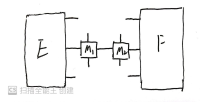

The eigenvectors we get are tensors with 4 legs.

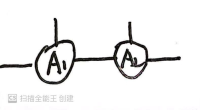

If we want  to conserve the $n$ lowest energy eigenstates $(n>1)$ of the total Hamiltonian MPO, we need to introduce a virtual index: Index $v$. The dimension of $v$ is equal to n. We need to save the $n$ lowest energy eigenstates of the effective Hamiltonian into the tensor shown below.

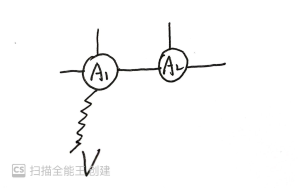

In order to do svd factorization, we need to reshape the tensor with 5 legs to a matrix.We construct two combiners:
$C_1: (e,f)=>i$ and $C_2: (a,b,c)=>j$. $C_1$ is a tensor with 3 legs and $C_2$ is a tensor with 4 legs.Then, we apply $C_1$ and $C_2$ on the above tensor, and we can get a matrix with only 2 indexes.

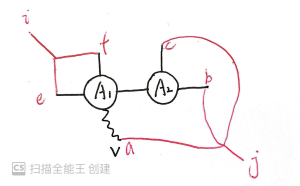

Then, we do svd factorization as the conventional DMRG method. We merge Tensor $S$ and Tensor $Vt$, in order to move the canonical center to the next site. 

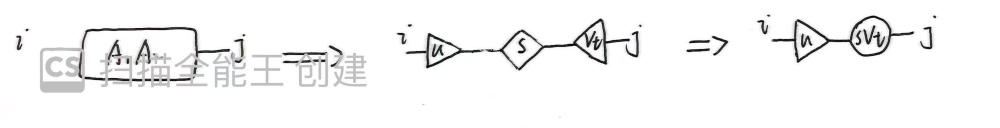

Then, we reshape the matrix back to the 5 leg tensors by applying $dag(C_1)$ and $dag(C_2)$ to it.

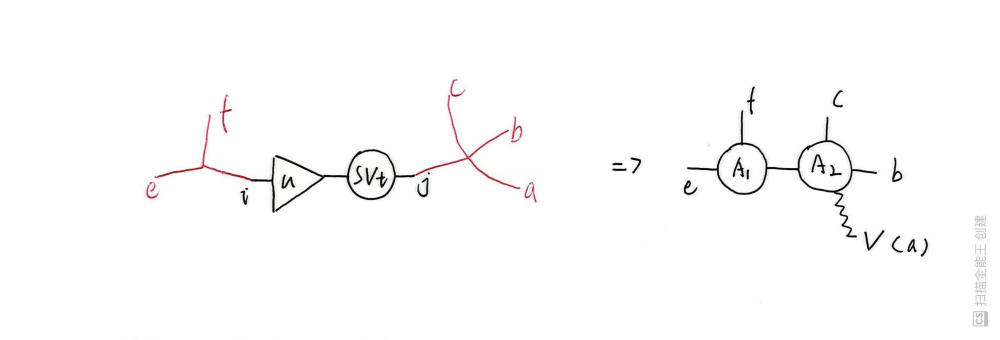

We find that the virtual index $v$ is moved to the next site. Actually, the virtual index $v$ is always attached to the canonical center.

Here is the sample code of 1D Heisenberg chain.

In [7]:
using Einsum
using TensorOperations
using KrylovKit
using LinearAlgebra
const nexcit=3
#initial E and F for the left and right vacuum states
function initial_E(W)
    E = zeros(1,size(W,1),1)
    E[1,1,1] = 1
    return E
end
function initial_F(W)
    F = zeros(1,size(W,3),1)
    F[1,end,1] = 1
    return F
end
# MPS-MPO-MPS contract from left
# here we use the macro: @einsum A[i, j] := B[i, k] * C[k, j]
function contract_from_left(W,A,E,B)
    @einsum tensor1[a,k,s,j] := E[i,a,k]*A[i,s,j]
    @einsum tensor2[k,j,b,t] := tensor1[a,k,s,j]*W[a,s,b,t]
    @einsum tensor3[j,b,l] := tensor2[k,j,b,t]*B[k,t,l]
    return tensor3
end
# MPS-MPO-MPS contract from right
function contract_from_right(W,A,F,B)
    @einsum tensor1[i,s,b,l] := F[j,b,l]*A[i,s,j]
    @einsum tensor2[i,a,t,l] := tensor1[i,s,b,l]*W[a,s,b,t]
    @einsum tensor3[i,a,k] := tensor2[i,a,t,l]*B[k,t,l]
    return tensor3
end
#construct F lib
# MPO is the W chain
# Alist and Blist are the MPS: the chain of A and B
# MF is the right boundary of F
function construct_F(Alist,MPO,Blist)
    MF = initial_F(MPO[end])
    F = [MF]
    for i = length(MPO):-1:2
        f = contract_from_right(MPO[i],Alist[i],F[1],Blist[i])
        F = vcat([f],F)
    end
    return F
end
#construct E lib
#ME is the left boundary of E
function construct_E(Alist,MPO,Blist)
    ME = initial_E(MPO[1])
    E = [ME]
    return E
end
# calculate expectation value of MPS
function Expectation(Alist,MPO,Blist)
    E = initial_E(MPO[1])
    for i = 1:length(MPO)
        E = contract_from_left(MPO[i],Alist[i],E,Blist[i])
    end
    return E[1,1,1]
end
# calculate Tensor norm
function Tensor_innter(T1,T2)
    @einsum T[m,n] := T1[i,j,m]*T2[i,j,n]
    return tr(T)
end
# coarse-graining of two site MPO into one site
function coarse_grain_MPO(W1,W2)
    @einsum W[a,s,u,c,t,v] := W1[a,s,b,t]*W2[b,u,c,v]
    ts = size(W) #tensor size
    W12 = reshape(W,(ts[1],ts[2]*ts[3],ts[4],ts[5]*ts[6]))
    return W12
end

function product_W(W1,W2)
    @einsum W[a,c,s,b,d,u] := W1[a,s,b,t]*W2[c,t,d,u]
    ts = size(W) #tensor size
    W12 = reshape(W,(ts[1]*ts[2],ts[3],ts[4]*ts[5],ts[6]))
    return W12
end

function product_MPO(MPO1,MPO2)
    @assert length(MPO1)==length(MPO2)
    result = []
    for i = 1:length(MPO1)
        result = vcat(result,[product_W(MPO1[i],MPO2[i])])
    end
    return result
end

# coarse-graining of two-site MPS in to one site
function coarse_grain_MPS(A1,A2,direction)
    if direction == "right"
        @einsum A12[i,s,t,k,m] := A1[i,s,j,m]*A2[j,t,k]
        ts = size(A12) #tensor size
        A12 = reshape(A12,(ts[1],ts[2]*ts[3],ts[4],ts[5]))
        return A12
    else 
        @assert direction =="left"
        @einsum A12[m,i,s,t,k] := A1[i,s,j]*A2[m,j,t,k]
        ts = size(A12) #tensor size
        A12 = reshape(A12,(ts[1],ts[2],ts[3]*ts[4],ts[5]))
        return A12
    end
end

function fine_grain_MPS(A,dims,direction)
    if direction == "right"
        @assert size(A,2) == dims[1]*dims[2]
        ts = size(A) #tensor size
        Theta = reshape(A,(ts[1],dims[1],dims[2],ts[3],ts[4]))
        @tensor Theta[s,i,t,k,m] := Theta[i,s,t,k,m]
        Theta = reshape(Theta,(ts[1]*dims[1],dims[2]*ts[3]*ts[4]))
        F  = svd(Theta)
        bond1 = length(F.U)/dims[1]/ts[1]
        bond2 = length(F.Vt)/dims[2]/ts[3]/ts[4]
        bond1 = convert(Int,bond1)
        bond2 = convert(Int,bond2)
        U = reshape(F.U,(dims[1],ts[1],bond1))
        Vt = reshape(F.Vt,(bond2,dims[2],ts[3],ts[4]))
        S = F.S
        return U,S,Vt
    else 
        @assert direction =="left"
        @assert size(A,3) == dims[1]*dims[2]
        ts = size(A) #tensor size
        Theta = reshape(A,(ts[1],ts[2],dims[1],dims[2],ts[4]))
        @tensor Theta[m,s,i,t,k] := Theta[m,i,s,t,k]
        Theta = reshape(Theta,(ts[1]*ts[2]*dims[1],dims[2]*ts[4]))
        F  = svd(Theta)
        bond1 = length(F.U)/dims[1]/ts[1]/ts[2]
        bond2 = length(F.Vt)/dims[2]/ts[4]
        bond1 = convert(Int,bond1)
        bond2 = convert(Int,bond2)
        U = reshape(F.U,(ts[1],dims[1],ts[2],bond1))
        Vt = reshape(F.Vt,(bond2,dims[2],ts[4]))
        S = F.S
        return U,S,Vt
    end     
end
function truncate_MPS(U,S,Vt,m,direction)
    if direction == "right"
        m = min(length(S),m)
        trunc = sum(S[m+1:end].*S[m+1:end])
        S = S[1:m]
        U = U[:,:,1:m]
        Vt = Vt[1:m,:,:,:]
        S = S/norm(S)
        return U,S,Vt,trunc,m
    else
        @assert direction =="left"
        m = min(length(S),m)
        trunc = sum(S[m+1:end].*S[m+1:end])
        S = S[1:m]
        U = U[:,:,:,1:m]
        Vt = Vt[1:m,:,:]
        S = S/norm(S)
        return U,S,Vt,trunc,m
    end 
end
function HamiltonianMultiply(E,W,F,A)
    @einsum tensor1[j,s,a,k] := E[i,a,k]*A[i,s,j]
    @einsum tensor2[j,b,t,k] := tensor1[j,s,a,k]*W[a,s,b,t]
    @einsum R[k,t,l] :=tensor2[j,b,t,k]*F[j,b,l]
    return R
end
function HamiltonianMultiply_matrix(E,W,F)
    @einsum tensor1[i,k,s,b,t] := E[i,a,k]*W[a,s,b,t]
    @einsum tensor2[k,t,l,i,s,j] := tensor1[i,k,s,b,t]*F[j,b,l]
    ts = size(tensor2)
    TT = reshape(tensor2,(ts[1]*ts[2]*ts[3],ts[4]*ts[5]*ts[6]))
    e,v = eigen(TT)
    e = e[1:nexcit]
    vec = Vector{Any}(undef, nexcit)
    for n = 1:nexcit
        vec[n] = reshape(v[:,n],(ts[4],ts[5],ts[6]))
    end
    return e,vec
end
function eigenvec_normalize(A,direction)
    if direction == "right"
        for n = 1:nexcit
            for m = 1:n-1
                A[:,:,:,n] = A[:,:,:,n]-Tensor_innter(A[:,:,:,n],A[:,:,:,m])*A[:,:,:,m]
            end
            A[:,:,:,n] = A[:,:,:,n]/sqrt(Tensor_innter(A[:,:,:,n],A[:,:,:,n]))
        end
    else
        @assert direction =="left"
        for n = 1:nexcit
            for m = 1:n-1
                A[n,:,:,:] = A[n,:,:,:]-Tensor_innter(A[n,:,:,:],A[m,:,:,:])*A[m,:,:,:]
            end
            A[n,:,:,:] = A[n,:,:,:]/sqrt(Tensor_innter(A[n,:,:,:],A[n,:,:,:]))
        end
    end
    return A/sqrt(nexcit)
end
function optimize_two_sites(A1,A2,W1,W2,E,F,m,direction)
    W = coarse_grain_MPO(W1,W2)
    H_eff(A) = HamiltonianMultiply(E,W,F,A)
    if direction== "right"
        A0 = coarse_grain_MPS(A1,A2,"right")
        AA = zeros(ComplexF64,size(A0))
        Eig,Alist,info = eigsolve(H_eff, A0[:,:,:,1], nexcit,:SR;ishermitian=true,eager=true)
        if length(Alist) < nexcit
            Eig,Alist = HamiltonianMultiply_matrix(E,W,F)
        end
        for n = 1:nexcit
            AA[:,:,:,n] = Alist[n]
        end
        U,S,Vt = fine_grain_MPS(AA,[size(A1,2),size(A2,2)],"right")
        U,S,Vt,trunc,m = truncate_MPS(U,S,Vt,m,"right")
        s_diag = diagm(S)
        @einsum A2[i,t,k,m] := s_diag[i,j]*Vt[j,t,k,m]
        @tensor U[i,s,j] := U[s,i,j]
        A2 = eigenvec_normalize(A2,"right")
        return Eig[1:nexcit],U,A2,trunc,m
    else
        @assert direction =="left"
        A0 = coarse_grain_MPS(A1,A2,"left")
        AA = zeros(ComplexF64,size(A0))
        Eig,Alist,info = eigsolve(H_eff, A0[1,:,:,:], nexcit,:SR;ishermitian=true,eager=true)
        if length(Alist) < nexcit
            Eig,Alist = HamiltonianMultiply_matrix(E,W,F)
        end
        for n = 1:nexcit
            AA[n,:,:,:] = Alist[n]
        end
        U,S,Vt = fine_grain_MPS(AA,[size(A1,2),size(A2,3)],"left")
        U,S,Vt,trunc,m = truncate_MPS(U,S,Vt,m,"left")
        s_diag = diagm(S)
        @einsum A1[m,i,s,j] := U[m,s,i,n]*s_diag[n,j]
        A1 = eigenvec_normalize(A1,"left")
        return Eig[1:nexcit],A1,Vt,trunc,m
    end
end

function two_site_dmrg(MPS,MPO,m,sweeps)
    E = construct_E(MPS,MPO,MPS)
    F = construct_F(MPS,MPO,MPS)
    deleteat!(F,1)
    for sweep = 1:(sweeps÷2)
        for i = 1:length(MPS)-2
            Energy,MPS[i],MPS[i+1],trunc,states = optimize_two_sites(MPS[i],MPS[i+1],MPO[i],MPO[i+1],E[end],F[1],m,"right")
            println("Sweep $(sweep*2-1)  Sites $i $(i+1) Eenrgy $Energy states $states trunc $trunc")
            e = contract_from_left(MPO[i],MPS[i],E[end],conj(MPS[i]))
            E = vcat(E,[e])
            deleteat!(F,1)
        end
        i = length(MPS)-1
        A0 = coarse_grain_MPS(MPS[i],MPS[i+1],"right")
        U,S,Vt = fine_grain_MPS(A0,[size(MPS[i],2),size(MPS[i+1],2)],"right")
        s_diag = diagm(S)
        @einsum A2[i,t,k,m] := s_diag[i,j]*Vt[j,t,k,m]
        @tensor U[i,s,j] := U[s,i,j]
        MPS[i] = U
        @tensor A2[m,i,t,k] := A2[i,t,k,m]
        MPS[i+1] = A2
        for i = length(MPS)-1:-1:2
            Energy,MPS[i],MPS[i+1],trunc,states = optimize_two_sites(MPS[i],MPS[i+1],MPO[i],MPO[i+1],E[end],F[1],m,"left")
            println("Sweep $(sweep*2) Sites $i $(i+1) Energy $Energy states $states trunc $trunc")
            f = contract_from_right(MPO[i+1],MPS[i+1],F[1],conj(MPS[i+1]))
            F = vcat([f],F)
            deleteat!(E,length(E))
        end
        i = 1
        A0 = coarse_grain_MPS(MPS[i],MPS[i+1],"left")
        U,S,Vt = fine_grain_MPS(A0,[size(MPS[i],2),size(MPS[i+1],3)],"left")
        s_diag = diagm(S)
        @einsum A1[m,i,s,j] := U[m,s,i,n]*s_diag[n,j]
        MPS[i+1] = Vt
        @tensor A1[i,t,k,m] := A1[m,i,t,k]
        MPS[i] = A1
    end
    return MPS
end
       

two_site_dmrg (generic function with 1 method)

In [8]:
d = 2 # local bond dimenstion
N = 100 #number of sites
D = 30#virtue bond dimenstion
InitialA1 = zeros(1,d,1)
InitialA1[1,1,1] = 1
InitialA2 = zeros(1,d,1)
InitialA2[1,2,1] = 1
#Initial State |010101010101>
MPS = repeat([InitialA1,InitialA2],convert(Int,N/2))
MPS = convert(Array{Any},MPS)
U0 = zeros(1,d,1,nexcit)
for n = 1:nexcit
    U0[:,:,:,n] = InitialA1[:,:,:]
end
deleteat!(MPS,1);
prepend!(MPS,[U0]);                

In [9]:
I = diagm([1,1])
Z = zeros(2,2)
Sz = [0.5 0;0 -0.5]
Sp = [0 0; 1 0]
Sm = [0 1; 0 0]
# define MPO element( except the element on two boundaries)
W = zeros(5,5,2,2) #[a,b,s,t]
W[1,1,:,:] = I
W[1,2,:,:] = Sz
W[1,3,:,:] = 0.5*Sp
W[1,4,:,:] = 0.5*Sm
W[2,5,:,:] = Sz
W[3,5,:,:] = Sm
W[4,5,:,:] = Sp
W[5,5,:,:] = I
@tensor W[a,s,b,t] := W[a,b,s,t]
# define the first element of MPO
Wfirst = zeros(1,5,2,2) #[a,b,s,t]
Wfirst[1,1,:,:] = I
Wfirst[1,2,:,:] = Sz
Wfirst[1,3,:,:] = 0.5*Sp
Wfirst[1,4,:,:] = 0.5*Sm
@tensor Wfirst[a,s,b,t] := Wfirst[a,b,s,t]
# define the last element of MPO
Wlast = zeros(5,1,2,2) #[a,b,s,t]
Wlast[2,1,:,:] = Sz
Wlast[3,1,:,:] = Sm
Wlast[4,1,:,:] = Sp
Wlast[5,1,:,:] = I
@tensor Wlast[a,s,b,t] := Wlast[a,b,s,t]
# construct MPO chain
MPO = vcat([Wfirst],repeat([W],N-2),[Wlast]);
HamSquared = product_MPO(MPO,MPO)
MPS = two_site_dmrg(MPS,MPO,D,8);

┌ Warning: Invariant subspace of dimension 2 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 2`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 1  Sites 1 2 Eenrgy [-25.059016994374947, -24.25, -23.940983005625053] states 2 trunc 0.0
Sweep 1  Sites 2 3 Eenrgy [-25.18969262078591, -24.076351822333066, -23.48395555688102] states 4 trunc 0.0
Sweep 1  Sites 3 4 Eenrgy [-25.437174543547968, -24.673268553508812, -24.04673790477002] states 6 trunc 0.0
Sweep 1  Sites 4 5 Eenrgy [-25.59085236814221, -25.345120866828655, -24.794743584147227] states 6 trunc 0.0
Sweep 1  Sites 5 6 Eenrgy [-25.81763010976667, -25.237273714862894, -24.679136040137028] states 6 trunc 0.0
Sweep 1  Sites 6 7 Eenrgy [-25.974345461500015, -25.346449565137316, -24.8415605832305] states 6 trunc 0.0
Sweep 1  Sites 7 8 Eenrgy [-26.180540142478524, -25.65220669125978, -25.166159166602032] states 6 trunc 0.0
Sweep 1  Sites 8 9 Eenrgy [-26.345793052640747, -25.78836466402427, -25.3229959097042] states 6 trunc 0.0
Sweep 1  Sites 9 10 Eenrgy [-26.5339325133264, -26.0067826852625, -25.563779617896916] states 6 trunc 0.0
Sweep 1  Sites 10 11 Eenrgy [-26.7064881323725

Sweep 2 Sites 99 100 Energy [-42.86842071175807, -42.5084279876262, -42.49710108604001] states 2 trunc 0.0
Sweep 2 Sites 98 99 Energy [-42.90394077180926, -42.54394830578795, -42.53258165948383] states 4 trunc 0.0
Sweep 2 Sites 97 98 Energy [-42.908876960056105, -42.623271162783674, -42.548884797372686] states 8 trunc 0.0
Sweep 2 Sites 96 97 Energy [-42.937948011220364, -42.625571809832046, -42.577955785774684] states 16 trunc 0.0
Sweep 2 Sites 95 96 Energy [-42.945815302233896, -42.72126264403744, -42.58582393744604] states 30 trunc 1.7248719139680022e-32
Sweep 2 Sites 94 95 Energy [-42.97149193670774, -42.72420660962535, -42.61150027468059] states 30 trunc 7.405597161811996e-17
Sweep 2 Sites 93 94 Energy [-42.98116948716339, -42.796103320894105, -42.62117951252417] states 30 trunc 2.180821909688646e-15
Sweep 2 Sites 92 93 Energy [-43.004808140572344, -42.80008788906803, -42.644817889363864] states 30 trunc 3.2737785699916168e-15
Sweep 2 Sites 91 92 Energy [-43.015692923410874, -42.85

Sweep 2 Sites 31 32 Energy [-43.88312760042276, -43.849525496873866, -43.804645105996585] states 30 trunc 9.995943396278028e-8
Sweep 2 Sites 30 31 Energy [-43.88401515652444, -43.85096298685927, -43.805454136731846] states 30 trunc 1.2726674323850922e-7
Sweep 2 Sites 29 30 Energy [-43.88627248954902, -43.85253929285715, -43.8090438037744] states 30 trunc 4.52563353773958e-8
Sweep 2 Sites 28 29 Energy [-43.88815624501748, -43.85554794598077, -43.81066883336044] states 30 trunc 1.915400640835335e-8
Sweep 2 Sites 27 28 Energy [-43.89043407419358, -43.857171257588945, -43.81421960700829] states 30 trunc 8.059835253502209e-9
Sweep 2 Sites 26 27 Energy [-43.89232019633219, -43.86010149551222, -43.81584775350836] states 30 trunc 4.125657953580768e-9
Sweep 2 Sites 25 26 Energy [-43.89454811585797, -43.86172398092165, -43.81924727430377] states 30 trunc 2.098591656370672e-9
Sweep 2 Sites 24 25 Energy [-43.89639916758845, -43.864518468734325, -43.82084834327177] states 30 trunc 1.316962818601501

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31



Sweep 3  Sites 1 2 Eenrgy ComplexF64[-44.09561584050747 + 0.0im, -44.06076274298637 + 0.0im, -44.03508021382685 + 0.0im] states 2 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 3  Sites 2 3 Eenrgy ComplexF64[-44.09561584050745 + 0.0im, -44.06076274298637 + 0.0im, -44.03508021382718 + 0.0im] states 4 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 3  Sites 3 4 Eenrgy ComplexF64[-44.09561584050741 + 0.0im, -44.06076274298645 + 0.0im, -44.03508021382707 + 0.0im] states 8 trunc 0.0
Sweep 3  Sites 4 5 Eenrgy [-44.09562328689689, -44.060770043951564, -44.03508659308986] states 16 trunc 0.0
Sweep 3  Sites 5 6 Eenrgy [-44.095626391149814, -44.060773414481694, -44.03508974995006] states 30 trunc 1.3072031124881884e-10
Sweep 3  Sites 6 7 Eenrgy [-44.09569712371529, -44.060821631108375, -44.03516575092318] states 30 trunc 2.2897822690664454e-10
Sweep 3  Sites 7 8 Eenrgy [-44.09686218025591, -44.06181024230201, -44.03655783350582] states 30 trunc 7.789705594709212e-9
Sweep 3  Sites 8 9 Eenrgy [-44.096969213123124, -44.06188645693685, -44.036989002615954] states 30 trunc 4.632351233648876e-9
Sweep 3  Sites 9 10 Eenrgy [-44.09835984847193, -44.06307069654498, -44.038611451479944] states 30 trunc 3.9259777241523405e-8
Sweep 3  Sites 10 11 Eenrgy [-44.09855199413984, -44.06319394164369, -44.03949071220617] states 30 trunc 2.7662205179665

Sweep 3  Sites 68 69 Eenrgy [-44.12387640111112, -44.082447321711584, -44.08242968239926] states 30 trunc 6.159504907407302e-5
Sweep 3  Sites 69 70 Eenrgy [-44.12413546866151, -44.082761518061844, -44.082732224745385] states 30 trunc 8.038689586982411e-5
Sweep 3  Sites 70 71 Eenrgy [-44.12431288889167, -44.082992596166996, -44.082955112055075] states 30 trunc 6.5616066841393e-5
Sweep 3  Sites 71 72 Eenrgy [-44.124538055197036, -44.083293623025085, -44.08320782377023] states 30 trunc 7.973183227527306e-5
Sweep 3  Sites 72 73 Eenrgy [-44.124688502464515, -44.0834982702509, -44.08339192019494] states 30 trunc 6.930920366052907e-5
Sweep 3  Sites 73 74 Eenrgy [-44.12487903614618, -44.08376368831646, -44.08361145675671] states 30 trunc 7.860636496267626e-5
Sweep 3  Sites 74 75 Eenrgy [-44.12500235658577, -44.08393953377897, -44.083757707695604] states 30 trunc 7.254884575777113e-5
Sweep 3  Sites 75 76 Eenrgy [-44.125157906315536, -44.08416541446621, -44.08394301248919] states 30 trunc 7.6936

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31



Sweep 4 Sites 99 100 Energy ComplexF64[-44.125519314698565 + 0.0im, -44.08500758417776 + 0.0im, -44.08438767350063 + 0.0im] states 2 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 4 Sites 98 99 Energy ComplexF64[-44.125519314698614 + 0.0im, -44.085007584178115 + 0.0im, -44.084387673500814 + 0.0im] states 4 trunc 0.0
Sweep 4 Sites 97 98 Energy ComplexF64[-44.12551931469884 + 0.0im, -44.08500758417827 + 0.0im, -44.08438767350111 + 0.0im] states 8 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 4 Sites 96 97 Energy [-44.12552396622677, -44.08501426183, -44.084394254279005] states 16 trunc 0.0
Sweep 4 Sites 95 96 Energy [-44.12552752393043, -44.08501720927676, -44.08439810966708] states 30 trunc 1.5162114601227478e-10
Sweep 4 Sites 94 95 Energy [-44.125541318226034, -44.08503532755111, -44.08441757118932] states 30 trunc 3.6094613308107227e-10
Sweep 4 Sites 93 94 Energy [-44.1255521504749, -44.085043751475574, -44.08442985377807] states 30 trunc 1.5280295137540293e-8
Sweep 4 Sites 92 93 Energy [-44.125576061324, -44.08507451103922, -44.0844639019462] states 30 trunc 7.178500132964206e-9
Sweep 4 Sites 91 92 Energy [-44.12559559836137, -44.085088329053576, -44.084488059630345] states 30 trunc 7.381392650574598e-8
Sweep 4 Sites 90 91 Energy [-44.125633907388824, -44.08513451963962, -44.084522637203804] states 30 trunc 3.993419700270189e-8
Sweep 4 Sites 89 90 Energy [-44.12566318957113, -44.085152909739264, -44.08456189597477] states 30 trunc 2.223097163391528e-7
Sweep 4 Sit

Sweep 4 Sites 30 31 Energy [-44.126603952451305, -44.08630149976693, -44.08553142825409] states 30 trunc 6.636728309109969e-5
Sweep 4 Sites 29 30 Energy [-44.126558962143, -44.08627604408528, -44.085493883369175] states 30 trunc 7.601190395143598e-5
Sweep 4 Sites 28 29 Energy [-44.126515475609814, -44.086255950219474, -44.08542185925537] states 30 trunc 6.929098251317509e-5
Sweep 4 Sites 27 28 Energy [-44.126466870045455, -44.086223107912325, -44.08538036272135] states 30 trunc 7.61458650921705e-5
Sweep 4 Sites 26 27 Energy [-44.12642127525191, -44.08620051985508, -44.0853087224401] states 30 trunc 7.159797131565028e-5
Sweep 4 Sites 25 26 Energy [-44.12636921110538, -44.08616104714238, -44.08526413992641] states 30 trunc 7.555183599910025e-5
Sweep 4 Sites 24 25 Energy [-44.126322148978474, -44.08613624372033, -44.08519371674778] states 30 trunc 7.315368312414287e-5
Sweep 4 Sites 23 24 Energy [-44.126267036759245, -44.0860908325372, -44.08514692305875] states 30 trunc 7.410406124129042e

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31



Sweep 5  Sites 1 2 Eenrgy ComplexF64[-44.125531990935116 + 0.0im, -44.08544727306499 + 0.0im, -44.08434838421822 + 0.0im] states 2 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 5  Sites 2 3 Eenrgy ComplexF64[-44.12553199093553 + 0.0im, -44.08544727306479 + 0.0im, -44.08434838421827 + 0.0im] states 4 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 5  Sites 3 4 Eenrgy ComplexF64[-44.12553199093553 + 0.0im, -44.08544727306547 + 0.0im, -44.084348384218096 + 0.0im] states 8 trunc 0.0
Sweep 5  Sites 4 5 Eenrgy [-44.12553668540614, -44.08545396652445, -44.08435497474627] states 16 trunc 0.0
Sweep 5  Sites 5 6 Eenrgy [-44.12554024587806, -44.0854569348302, -44.08435882974726] states 30 trunc 1.5054857885761159e-10
Sweep 5  Sites 6 7 Eenrgy [-44.125554130645675, -44.08547522039024, -44.0843782662073] states 30 trunc 3.5686968270987796e-10
Sweep 5  Sites 7 8 Eenrgy [-44.12556496623213, -44.08548372029816, -44.08439053999773] states 30 trunc 1.5175927040842827e-8
Sweep 5  Sites 8 9 Eenrgy [-44.125589189428794, -44.085514855795665, -44.08442427939347] states 30 trunc 7.124109384953811e-9
Sweep 5  Sites 9 10 Eenrgy [-44.12560874504194, -44.08552882091511, -44.084448337457] states 30 trunc 7.313538052113075e-8
Sweep 5  Sites 10 11 Eenrgy [-44.12564629785343, -44.085576462538626, -44.084483477084305] states 30 trunc 3.969893245351422e-8

Sweep 5  Sites 68 69 Eenrgy [-44.12670373354738, -44.08638887066063, -44.085624953922746] states 30 trunc 6.323675447261179e-5
Sweep 5  Sites 69 70 Eenrgy [-44.12666030641991, -44.086360325872405, -44.08559554015855] states 30 trunc 7.541414925509822e-5
Sweep 5  Sites 70 71 Eenrgy [-44.12661914046326, -44.0863376732762, -44.0855230142762] states 30 trunc 6.66206657221464e-5
Sweep 5  Sites 71 72 Eenrgy [-44.12657214811276, -44.086302917898784, -44.0854879797012] states 30 trunc 7.610081442368498e-5
Sweep 5  Sites 72 73 Eenrgy [-44.1265284945711, -44.086278636425476, -44.08541534614315] states 30 trunc 6.953244346147559e-5
Sweep 5  Sites 73 74 Eenrgy [-44.126478092545085, -44.08623838354005, -44.08537554315041] states 30 trunc 7.61764101247913e-5
Sweep 5  Sites 74 75 Eenrgy [-44.12643250621625, -44.08621257831447, -44.085303619203515] states 30 trunc 7.182053337247359e-5
Sweep 5  Sites 75 76 Eenrgy [-44.12637898847792, -44.08616742985754, -44.08526029881853] states 30 trunc 7.54691130293

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31



Sweep 6 Sites 99 100 Energy ComplexF64[-44.12553610694942 + 0.0im, -44.08543812918228 + 0.0im, -44.08434395252819 + 0.0im] states 2 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 6 Sites 98 99 Energy ComplexF64[-44.1255361069496 + 0.0im, -44.08543812918225 + 0.0im, -44.08434395252835 + 0.0im] states 4 trunc 0.0
Sweep 6 Sites 97 98 Energy ComplexF64[-44.125536106949816 + 0.0im, -44.08543812918273 + 0.0im, -44.084343952528435 + 0.0im] states 8 trunc 0.0
Sweep 6 Sites 96 97 Energy [-44.12554080117141, -44.085444820761936, -44.08435054269168] states 16 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 6 Sites 95 96 Energy [-44.125544360839385, -44.08544778851849, -44.08435439824815] states 30 trunc 1.5060353413522124e-10
Sweep 6 Sites 94 95 Energy [-44.12555824451568, -44.08546606590134, -44.08437383615602] states 30 trunc 3.5706675816327733e-10
Sweep 6 Sites 93 94 Energy [-44.12556907704003, -44.08547456359094, -44.08438611275108] states 30 trunc 1.5181716190205777e-8
Sweep 6 Sites 92 93 Energy [-44.125593288711016, -44.08550569086414, -44.084419862194764] states 30 trunc 7.126943045779656e-9
Sweep 6 Sites 91 92 Energy [-44.12561283518962, -44.085519652217485, -44.08444393089264] states 30 trunc 7.3173589883085e-8
Sweep 6 Sites 90 91 Energy [-44.125650455414814, -44.08556722108187, -44.08447903478551] states 30 trunc 3.971227547741706e-8
Sweep 6 Sites 89 90 Energy [-44.12567963268347, -44.08558593800785, -44.084518088443666] states 30 trunc 2.2034235537987577e-7
Sweep 6 Sites 88 89 Energy [-44.12572671956912, -44.08564011891287, -44.08455894053399] states 30 trunc 1.213413662

Sweep 6 Sites 30 31 Energy [-44.12661960295799, -44.086336878261456, -44.085523042905095] states 30 trunc 6.661618627215143e-5
Sweep 6 Sites 29 30 Energy [-44.126572576322516, -44.0863022840237, -44.08548785960387] states 30 trunc 7.608955730510744e-5
Sweep 6 Sites 28 29 Energy [-44.12652887338196, -44.08627805906136, -44.08541520973213] states 30 trunc 6.952768990346441e-5
Sweep 6 Sites 27 28 Energy [-44.12647844728739, -44.08623791998496, -44.085375296197654] states 30 trunc 7.616047354620448e-5
Sweep 6 Sites 26 27 Energy [-44.12643282490399, -44.08621215690971, -44.0853033646908] states 30 trunc 7.181539203530285e-5
Sweep 6 Sites 25 26 Energy [-44.12637930410232, -44.0861670886216, -44.08525996996946] states 30 trunc 7.544189317027087e-5
Sweep 6 Sites 24 25 Energy [-44.12633189692733, -44.08614049386613, -44.0851888073536] states 30 trunc 7.3284183499028e-5
Sweep 6 Sites 23 24 Energy [-44.12627567803456, -44.08609106381958, -44.085142773180806] states 30 trunc 7.394291349881806e-5
S

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 7  Sites 2 3 Eenrgy ComplexF64[-44.1255360160279 + 0.0im, -44.08543826380886 + 0.0im, -44.08434399300245 + 0.0im] states 4 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 7  Sites 3 4 Eenrgy ComplexF64[-44.12553601602744 + 0.0im, -44.08543826380983 + 0.0im, -44.08434399300229 + 0.0im] states 8 trunc 0.0
Sweep 7  Sites 4 5 Eenrgy [-44.12554071024102, -44.08544495553844, -44.08435058320197] states 16 trunc 0.0
Sweep 7  Sites 5 6 Eenrgy [-44.12554426996306, -44.08544792332043, -44.0843544387291] states 30 trunc 1.5059860691723743e-10
Sweep 7  Sites 6 7 Eenrgy [-44.12555815370678, -44.08546620112755, -44.08437387670063] states 30 trunc 3.5705500545256906e-10
Sweep 7  Sites 7 8 Eenrgy [-44.125568986457296, -44.08547469889862, -44.08438615313371] states 30 trunc 1.5181319958515266e-8
Sweep 7  Sites 8 9 Eenrgy [-44.12559319845334, -44.08550582662962, -44.08441990268951] states 30 trunc 7.126777705338344e-9
Sweep 7  Sites 9 10 Eenrgy [-44.125612745608606, -44.0855197879651, -44.084443970805765] states 30 trunc 7.317101372571518e-8
Sweep 7  Sites 10 11 Eenrgy [-44.125650360279955, -44.08556736378281, -44.08447907681485] states 30 trunc 3.971146256235823e-8

Sweep 7  Sites 68 69 Eenrgy [-44.12670428617477, -44.086387809856795, -44.08562517745218] states 30 trunc 6.323347492747434e-5
Sweep 7  Sites 69 70 Eenrgy [-44.126660818361565, -44.08635947623313, -44.08559557290661] states 30 trunc 7.540460620798627e-5
Sweep 7  Sites 70 71 Eenrgy [-44.12661959535335, -44.08633689470279, -44.08552302084626] states 30 trunc 6.661640607508668e-5
Sweep 7  Sites 71 72 Eenrgy [-44.126572571155705, -44.08630229391138, -44.085487842992045] states 30 trunc 7.608958141738666e-5
Sweep 7  Sites 72 73 Eenrgy [-44.12652887049331, -44.086278066425784, -44.08541519281664] states 30 trunc 6.952787092615151e-5
Sweep 7  Sites 73 74 Eenrgy [-44.12647844647372, -44.086237922606365, -44.08537528299593] states 30 trunc 7.616047161703159e-5
Sweep 7  Sites 74 75 Eenrgy [-44.126432825875504, -44.08621215764068, -44.08530335129751] states 30 trunc 7.181551133060634e-5
Sweep 7  Sites 75 76 Eenrgy [-44.12637930670464, -44.086167086102364, -44.08525995894118] states 30 trunc 7.544

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31
┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 8 Sites 98 99 Energy ComplexF64[-44.12553602622985 + 0.0im, -44.08543825154672 + 0.0im, -44.08434398748411 + 0.0im] states 4 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 8 Sites 97 98 Energy ComplexF64[-44.1255360262305 + 0.0im, -44.085438251547906 + 0.0im, -44.08434398748476 + 0.0im] states 8 trunc 0.0
Sweep 8 Sites 96 97 Energy [-44.1255407204424, -44.08544494327338, -44.08435057768263] states 16 trunc 0.0


┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 8 Sites 95 96 Energy [-44.125544280163055, -44.08544791105442, -44.084354433210876] states 30 trunc 1.5059875618339063e-10
Sweep 8 Sites 94 95 Energy [-44.12555816390103, -44.085466188852735, -44.0843738711797] states 30 trunc 3.570554314671323e-10
Sweep 8 Sites 93 94 Energy [-44.125568996645214, -44.08547468661998, -44.08438614761814] states 30 trunc 1.5181333488910606e-8
Sweep 8 Sites 92 93 Energy [-44.1255932086245, -44.0855058143411, -44.08441989717172] states 30 trunc 7.126783789769981e-9
Sweep 8 Sites 91 92 Energy [-44.125612755761026, -44.08551977567446, -44.08444396530746] states 30 trunc 7.317110206310259e-8
Sweep 8 Sites 90 91 Energy [-44.12565037060604, -44.08556735127012, -44.08447907124827] states 30 trunc 3.971149347314862e-8
Sweep 8 Sites 89 90 Energy [-44.12567954880973, -44.08558606827639, -44.08451812352868] states 30 trunc 2.2033535814880015e-7
Sweep 8 Sites 88 89 Energy [-44.12572663294416, -44.0856402544906, -44.08455897702156] states 30 trunc 1.2133896614450

Sweep 8 Sites 29 30 Energy [-44.126572571573945, -44.086302293594755, -44.08548784325162] states 30 trunc 7.6089578986615e-5
Sweep 8 Sites 28 29 Energy [-44.12652887078336, -44.0862780662058, -44.08541519314112] states 30 trunc 6.952786795920085e-5
Sweep 8 Sites 27 28 Energy [-44.12647844666639, -44.08623792253183, -44.08537528327247] states 30 trunc 7.616046969501985e-5
Sweep 8 Sites 26 27 Energy [-44.12643282597394, -44.08621215764399, -44.08530335162078] states 30 trunc 7.181551531630237e-5
Sweep 8 Sites 25 26 Energy [-44.12637930673568, -44.08616708621979, -44.085259959256504] states 30 trunc 7.544189414680213e-5
Sweep 8 Sites 24 25 Energy [-44.12633190113935, -44.086140489947454, -44.08518879675021] states 30 trunc 7.328422819186098e-5
Sweep 8 Sites 23 24 Energy [-44.126275683368796, -44.086091057930226, -44.08514276400769] states 30 trunc 7.394292091478755e-5
Sweep 8 Sites 22 23 Energy [-44.12622775557355, -44.0860632888879, -44.08507393507503] states 30 trunc 7.389930088950856e-

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 3`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\wqyan\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:31


Sweep 8 Sites 2 3 Energy ComplexF64[-44.125536025864434 + 0.0im, -44.085438252006824 + 0.0im, -44.08434398759033 + 0.0im] states 12 trunc 0.0


In [10]:
psi0 = copy(MPS)
deleteat!(psi0,1);
T1 = MPS[1][:,:,:,1]
nT1 = Tensor_innter(T1,T1)
@show nT1
prepend!(psi0,[T1/sqrt(nT1)]);
E1 = Expectation(psi0,MPO,psi0)
println("Ground state energy expectation value $E1")
psi1 = copy(MPS)
deleteat!(psi1,1);
T2 = MPS[1][:,:,:,2]
nT2 = Tensor_innter(T2,T2)
prepend!(psi1,[T2/sqrt(nT2)]);
E2 = Expectation(psi1,MPO,psi1)
println("First excited state energy expectation value $E2")

nT1 = 0.333333333333333 + 0.0im
Ground state energy expectation value -44.12553602586438 + 0.0im
First excited state energy expectation value -44.08543825200686 + 0.0im
